In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] ='-1'  #don't use graphics card

import sys
import gc

#Import from the Keras library
from keras import models
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,  MaxPooling2D
from keras import optimizers 
from keras import utils
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

#This allows for Keras models to be saved. 
import h5py
#Other import statements 
import h5py
import random
import numpy as np
import pandas as pd
import pathlib
import cv2
import pymysql

import statistics
from livelossplot import PlotLosses #install livelossplot with pip for graphical feedback during training


#pick which recordings you are working with
#where_clause = "WHERE (r.recording_id > 1)"
where_clause = "WHERE (r.recording_id > 1)"

#limit the data to a subset for testing
#Make empty string to have no limit
#limit = "ORDER BY RAND(1) LIMIT 3000"
limit_clause = "ORDER BY RAND(1)"

#What size should we reduce images to before learning in percent
#image_scale_percent = 1

epochs = 500
batch_size = 24
max_accuracy = 0.95 #Quit if accuracy reaches this at any epoch
loss_threshold = 0.01 #Stop training if accuracy isn't changing and loss changes by less than this percentage

#directory where data from database is stored
cache_path = 'cache'

#File name for the statistics to be save in. Must include .txt at the end
statistics_output_file = 'statistics.output.txt'

#Must have the h5py package installed or the model will not save. This should be the path of the location you would like
#To save the model
model_file_name = 'model.output'

Using TensorFlow backend.


In [2]:
#Secrets shouldn't be in the repository
from secrets import credentials
# Of the form
#credentials = {
#        'db_host' : 'something.us-east-1.rds.amazonaws.com'
#        'db_port' : 3306
#        'db_name' : 'name',
#        'db_username' : 'something',
#        'db_password' : 'secret'
#        }


def connect(): 
    db_host = credentials['db_host'];
    db_port = credentials['db_port'];
    db_name = credentials['db_name'];
    db_username = credentials['db_username']
    db_password = credentials['db_password']
    
    conn = pymysql.connect(db_host, user=db_username, port=db_port, passwd=db_password, db=db_name)
    return conn

In [3]:
def create_model(input_shape, keys=[0,1,2], filter_info={0:[32,3]}, dropout={0:0.25}, pooling={0:2}, activation='relu', loss='mean_squared_error', final_activation='sigmoid',dense_layer=256):    
    
    model = models.Sequential() 
    for k in keys:
        num_filters = filter_info[k][0]
        filter_size = filter_info[k][1]
        if k == keys[0]: 
            model.add(Conv2D(num_filters, (filter_size,filter_size), activation = 'relu', input_shape=input_shape))
        else: 
            model.add(Conv2D(num_filters, (filter_size,filter_size), activation= 'relu'))
                
        if k in pooling.keys():           
            pool_filter_size = pooling[k]
            model.add(MaxPooling2D(pool_size=(pool_filter_size, pool_filter_size)))            
                 
        if k in dropout.keys(): 
            drop_rate = dropout[k]
            model.add(Dropout(drop_rate))
    
    #These will be added to the end of every model no matter what
    model.add(Flatten())
    model.add(Dense(dense_layer,activation=activation))
    model.add(Dropout(0.5))
    
    #Sigmoid activiation is employed in the final step ***This assumes the output is binary***. 
    model.add(Dense(1, activation=final_activation)) 
    
    model.compile(loss=loss, 
              optimizer=optimizers.SGD(lr=1e-4),
              metrics=['acc']) 

    return model


In [4]:
keys=[0,1,2]
filter_info={0:[32,3],1:[64,3],2:[128,3]}
dropout={0:0.25,1:0.25,2:0.25}
pooling={0:2,1:2,2:2}

#Clean up memory
model=None
tf.keras.backend.clear_session() #make sure no old model is taking up memory
gc.collect()

model = create_model( (480,640,3),
                    keys,
                    filter_info=filter_info,
                    dropout=dropout,
                    pooling=pooling,
                    loss='mean_squared_error', 
                    final_activation='sigmoid',
                    activation='relu',
                    dense_layer=256)

#Start the new output file
with open(statistics_output_file, 'w') as f:
    from tensorflow.python.client import device_lib
    using_gpu = False
    for d in device_lib.list_local_devices():
        if d.device_type == "GPU":
            using_gpu = True

    if using_gpu:
        f.write('Used GPU: True\n')
    else:
        f.write('Used GPU: False\n')
        
    f.write("where_clause:\"{}\"\n".format(where_clause))
    f.write("limit_clause:\"{}\"\n".format(limit_clause))
    f.write("epochs:\"{}\"\n".format(epochs))
    f.write("batch_size:\"{}\"\n".format(batch_size))
    f.write("max_accuracy:\"{}\"\n\n".format(max_accuracy))
    f.write("loss_threshold:\"{}\"\n\n".format(loss_threshold))
    f.write("Model:\n")
    model.summary(print_fn=lambda x: f.write("{}\n".format(x)))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
def import_class_data(conn): 
    
    cursor = conn.cursor()
    try:
        #a dictionary that maps classes to a dictionary that maps recording_ids to a set of raw_ids
        ''' 2 classes , 2 recording ids, 15 frames
            {
                0:{
                    2:{1,2,3,4},
                    3:{5,6,7,8}
                },
                1:{
                    2:{9,10,11,12},
                    3:{13,14,15}
                }
            }
        '''
                    
        class_data={}
        
        recording_query = "SELECT r.id, r.recording_id, r.isCSGM FROM nicu.Video_Raw AS r JOIN nicu.Video_Generated AS g ON r.id=g.raw_id "+where_clause+" "+limit_clause
        try:
            cursor.execute(recording_query)
            for row in cursor.fetchall():
                raw_id = row[0]
                rec_id = row[1]
                csgm = row[2]
                
                if csgm not in class_data:
                    class_data[csgm] = dict()
                    
                single_class_data = class_data[csgm]
                
                if rec_id not in single_class_data:
                    single_class_data[rec_id] = set()
                    
                single_class_data[rec_id].add(raw_id)
                                                      
        except Exception as e:
            print("Error retrieving ID's", e)
            conn.rollback()
            raise e
            
        return class_data
    finally:
        cursor.close()
    

In [6]:
def import_data_batch(cache_path,conn,recording_ids,page,batch_size=32):

    #Create the cache directory if it doesn't exist
    if not os.path.exists(cache_path):
        os.mkdir(cache_path)
        
    cursor = conn.cursor()

    try:
        recording_ids = {}
        xy = {}    
        
        image_query = "SELECT r.id, r.recording_id, r.isCSGM FROM nicu.Video_Raw AS r JOIN nicu.Video_Generated AS g ON r.id=g.raw_id  WHERE (r.recording_id>1) AND (g.RGB_Optical_Flow IS NOT NULL) " +limit
        try:
            cursor.execute(image_query) #(list(recording_ids.keys())))
            for row in cursor.fetchall():
                raw_id = row[0]
                rec_id = row[1]
                csgm = row[2]
                if rec_id in recording_ids:
                    recording_ids.get(rec_id).append(raw_id)
                else:
                    recording_ids.update({rec_id:[raw_id]})
                xy.update({raw_id:[csgm]})
        except Exception as e:
            print("Error retrieving ID's", e)
            conn.rollback()
            raise e
            
        print("Collecting images for processing (o = source image in cache, ⇣ = source image fetched from db, x = source image not in db)")
        for rec_id in recording_ids:
            print("")
            print("Analyzing recording_id:",rec_id,": ",end="")
            raw_id_list = recording_ids.get(rec_id)
            for raw_id in raw_id_list:
                current_input = cache_path+'/'+str(raw_id)+".oflow.png"
                if not os.path.exists(current_input):
                    cursor2 = conn.cursor()
                    try:
                        image_query = "SELECT RGB_Optical_Flow from Video_Generated WHERE (raw_id=%s)"
                        cursor2.execute(image_query, (str(raw_id)))
                        for row in cursor2.fetchall():
                            db_img = row[0]
                            if db_img is not None:
                                img=cv2.imdecode(np.asarray(bytearray(db_img),dtype=np.uint8),cv2.IMREAD_UNCHANGED)
                                cv2.imwrite(current_input,img)
                                print("⇣",end="",flush=True)
                            else:
                                print("x",end="",flush=True)
                    except Exception as e:
                        print("Error retrieving Optical Flow frame",e)
                        raise e
                    finally:
                        cursor2.close()     
                else:
                    print("o",end="",flush=True)

                #Resizing the image
                img = cv2.imread(current_input)
              
                width = int(img.shape[1] * image_scale_percent / 100)
                height = int(img.shape[0] * image_scale_percent / 100)
                cv2.resize(img,(width,height), interpolation=cv2.INTER_CUBIC)
                xy.get(raw_id).insert(0,img)
        print("")
        return recording_ids, xy
    finally:
        cursor.close()
    

In [7]:
def create_array(conn, class_data, batch_raw_ids):     
    
    #Find the true class of the elements in the batch
    raw_id_dict = {} #The raw_id mapped to the class
    all_classes = class_data.keys()
    for a_class in all_classes:
        for recording_id, raw_ids in class_data[a_class].items():
            for raw_id in raw_ids:
                if raw_id in batch_raw_ids:
                    raw_id_dict[raw_id] = a_class
    
    #Retrieve the images
    image_list=[]
    csgm_list=[]
    
    for raw_id,the_class in raw_id_dict.items():
        #Check the cache for the image in question
        current_input = cache_path+'/'+str(raw_id)+".oflow.png"
        if not os.path.exists(current_input):
            cursor = conn.cursor()
            try:
                image_query = "SELECT RGB_Optical_Flow from Video_Generated WHERE (raw_id=%s)"
                cursor.execute(image_query, (str(raw_id)))
                for row in cursor.fetchall():
                    db_img = row[0]
                    if db_img is not None:
                        img=cv2.imdecode(np.asarray(bytearray(db_img),dtype=np.uint8),cv2.IMREAD_UNCHANGED)
                        cv2.imwrite(current_input,img)
                        print("⇣",end="",flush=True)
                    else:
                        print("x",end="",flush=True)
            except Exception as e:
                print("Error retrieving Optical Flow frame",e)
                raise e
            finally:
                cursor.close()     
        else:
            print("o",end="",flush=True)

        img = cv2.imread(current_input)
        if img is not None: 
            #Resizing the image
            #width = int(img.shape[1] * image_scale_percent / 100)
            #height = int(img.shape[0] * image_scale_percent / 100)
            #cv2.resize(img,(width,height), interpolation=cv2.INTER_CUBIC)
            image_list.append(img)
            csgm_list.append(the_class)
        
    x = np.array(image_list)
    y = np.array(csgm_list)
    return x, y
        

In [8]:
def convert_predictions(predictions): 
    """
    Converts predictions outputted by a keras model into a list with 1 represented the predicted output and zero 
    in other classes. 
    """
    l =[]
    for p in predictions: 
        if p >= 0.5:
            l.append(1)
        else:
            l.append(0)
    return l

In [9]:
def confusion_matrix(exp_values, predicted_values):
    """
    This creates a confusion matrix with the predicted accuracy of the model.
    
    exp_values must be in the format of a list and predicted values is expected to come in the format of the output 
    of Keras's model.predict()
    
    The output is a pandas dataframe that displays a confusion matrix indicative of the accuracy of the model along 
        with a number score which is the accuracy of the model.
    """
    predicted_values = convert_predictions(predicted_values)
    
    #Creates a DataFrame of zeros
    matrix = pd.DataFrame(np.zeros((2,2)) , ['P0','P1'], ['E0','E1'])
   
    #Caculates whether the score was right or wrong and updates the confusion matrix 
    for i in range(len(exp_values)):
        if exp_values[i] == predicted_values[i]:
            matrix.iloc[[predicted_values[i]],[predicted_values[i]]] += 1
        else:
            matrix.iloc[[predicted_values[i]],[exp_values[i]]] += 1
   
    #Calculate diagonal sum and the accuracy of the model
    #Precision (TP/TP+FPos)      Recall TP(TP+FNegative)
    diagonal_sum = 0
    for i in range(2):
        diagonal_sum += matrix.iloc[i][i]
    
    score = diagonal_sum/len(exp_values)
    
    return  matrix, score
    
    
            


In [10]:
def runTest(model,pooling, dropout, filter_info, file_name='model.txt', model_name='model', epochs=5, batch_size=32,max_accuracy=0.90):
    
    conn = connect()
    try:
        #Continue output
        with open(file_name, 'a') as output_file:
            output_file.write("Fold, Accuracy, Loss, TN, FN, FP, TP, Stop Reason\n")
            
            #recording_ids_dict = import_recording_ids(cache_path,conn)
            class_data = import_class_data(conn)
        
            all_classes = class_data.keys()

            results = []
            
            #Set up to do cross-validation
            all_recording_ids = set()
            for a_class in all_classes:
                for recording_id in class_data[a_class].keys():
                    all_recording_ids.add(recording_id)

            #Run one fold of cross validation
            for test_recording_id in all_recording_ids:
                output_file.write("{},".format(test_recording_id))
                liveplot = PlotLosses()

                #Clean up some memory by garbage collecting variables that hold data
                train_ids = train_ids_list = test_ids = x_train = y_train = x_test = y_test = None
                gc.collect()
        
                print('Testing on {0:3} '.format(test_recording_id),end="")
                train_ids= set()
                test_ids = set()
        
                #Given the recording we are using for testing, split up the raw_ids into training and testing groups
                for recording_id in all_recording_ids:
                    raw_ids = set()
                    for a_class in all_classes:
                        for key, values in class_data[a_class].items():
                            if key == recording_id:
                                for value in values:
                                    raw_ids.add(value)
                
                    if test_recording_id == recording_id:
                        test_ids = test_ids.union(raw_ids)
                    else: 
                        train_ids = train_ids.union(raw_ids)
                    
                #Create the testing set
                x_test, y_test = create_array(conn,class_data,test_ids)
                print()
        
                #Scaling the values to a value between 0 and 1
                x_test = x_test.astype('float32')
                x_test /= 255
        
                epoch = 0
                accuracy = 0.0  #poor accuracy
                loss = 1.0 #poor loss
                average_delta_loss_percentage = 1.0 #poor delta
                while epoch < epochs and accuracy < max_accuracy and average_delta_loss_percentage > loss_threshold:
                    #Split the train_ids up into batches that are randomly shuffled and iteratively train themodel
                    train_ids_list = list(train_ids)
                    random.shuffle(train_ids_list)
                
                    print("\tFold: {}, Epoch: {}, Samples: {} ".format(test_recording_id,epoch,len(train_ids_list)),end="")
                
                    #Go through a batch at a time
                    for i in range(0,len(train_ids_list), batch_size):
                        #Get the current batch
                        batch = set()
                        for j in range(i,i+batch_size):
                            if j < len(train_ids_list):
                                batch.add(train_ids_list[j])
                    
                        #Fetch the images for the batch
                        print(" {} ".format(i),end="",flush=True)
                        x_batch, y_batch = create_array(conn,class_data,batch)
                
                        #Scaling the rgb values to a value between 0 and 1
                        x_batch = x_batch.astype('float32')
                        x_batch /= 255
                
                        #Fit the model
                        model.train_on_batch(x_batch, y_batch)
                    print("",flush=True)
              
                    #Create predictions and evaluate to find loss and accuaracy
                    predict = model.predict(x_test)
                    model_score = model.evaluate(x=x_test,y=y_test)
                   
                    matrix,score = confusion_matrix(y_test, predict)
                    
                    #update epoch
                    epoch = epoch + 1
                    
                    #figure out loss change
                    delta_loss_percentage = abs(loss - model_score[0])/loss
                    
                    #update loss
                    loss = model_score[0]
                    
                    #if accuracy didn't change...
                    if accuracy == model_score[1]:    
                        average_delta_loss_percentage = 0.9*average_delta_loss_percentage + 0.1*delta_loss_percentage
                    else:
                        average_delta_loss_percentage = 1.0
                        
                    #update accuracy
                    accuracy = model_score[1]
                    
                    liveplot.update({
                        'accuracy': accuracy,
                        'mse':loss
                    })
                    liveplot.draw()
                    
                    print("\t\tModel accuracy: {}, loss: {}, delta loss percentage: {}, average delta loss percentage: {}".format(model_score[1],model_score[0],delta_loss_percentage,average_delta_loss_percentage))
                    print("{}\n".format(matrix))
                
                if epoch == epochs:
                    stop_reason = "Finished all epochs"
                if accuracy >= max_accuracy:
                    stop_reason = "max_accuracy was reached"
                if average_delta_loss_percentage < loss_threshold:
                    stop_reason = "Training stopped progressing"
                print(stop_reason)
                
                results.append({"matrix":matrix,
                                 "score":score,
                                 "model_score":model_score
                                }) 
                
                output_file.write("{},".format(accuracy))
                output_file.write("{},".format(loss))
                output_file.write("{},".format(matrix.iloc[0][0]))
                output_file.write("{},".format(matrix.iloc[0][1]))
                output_file.write("{},".format(matrix.iloc[1][0]))
                output_file.write("{},".format(matrix.iloc[1][1]))  
                output_file.write("{}\n".format(stop_reason))
            aggregate_accuracy = []
            aggregate_loss = []
            aggregate_TN = []
            aggregate_FN = []
            aggregate_FP = []
            aggregate_TP = []
            for r in results:
                aggregate_accuracy.append(r["model_score"][1])
                aggregate_loss.append(r["model_score"][0])
                aggregate_TN.append(r["matrix"].iloc[0][0])
                aggregate_FN.append(r["matrix"].iloc[0][1])
                aggregate_FP.append(r["matrix"].iloc[1][0])
                aggregate_TP.append(r["matrix"].iloc[1][1])
            output_file.write("Across all folds:\n")
            output_file.write("Average Accuracy: {}, Standard Deviation: {}\n".format(statistics.mean(aggregate_accuracy),statistics.stdev(aggregate_accuracy)))
            output_file.write("Average Loss: {}, Standard Deviation: {}\n".format(statistics.mean(aggregate_loss),statistics.stdev(aggregate_loss)))
            output_file.write("\t\t\tEO\tE1\n")
            output_file.write("\tP0\t{}\t{}\n".format(sum(aggregate_TN),sum(aggregate_FN)))
            output_file.write("\tP0\t{}\t{}\n".format(sum(aggregate_FP),sum(aggregate_TP)))

        return model
    finally:
        conn.close()

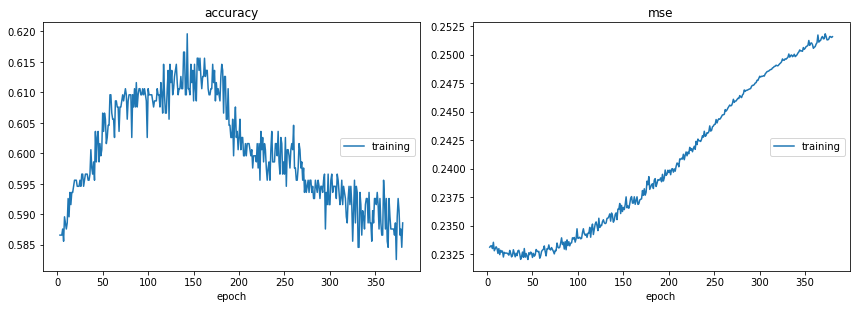

accuracy:
training   (min:    0.583, max:    0.620, cur:    0.589)

mse:
training   (min:    0.232, max:    0.252, cur:    0.252)
		Model accuracy: 0.5885885887079172, loss: 0.25157568631348787, delta loss percentage: 0.0002618605142607072, average delta loss percentage: 1.0
       E0     E1
P0  428.0  260.0
P1  151.0  160.0

	Fold: 4, Epoch: 380, Samples: 11000  0 oooooooooooooooooooooooo 24 oooooooooooooooooooooooo 48 oooooooooooooooooooooooo 72 oooooooooooooooooooooooo 96 oooooooooooooooooooooooo 120 oooooooooooooooooooooooo 144 oooooooooooooooooooooooo 168 oooooooooooooooooooooooo 192 oooooooooooooooooooooooo 216 oooooooooooooooooooooooo 240 oooooooooooooooooooooooo 264 oooooooooooooooooooooooo 288 oooooooooooooooooooooooo 312 oooooooooooooooooooooooo 336 oooooooooooooooooooooooo 360 oooooooooooooooooooooooo 384 oooooooooooooooooooooooo 408 oooooooooooooooooooooooo 432 oooooooooooooooooooooooo 456 oooooooooooooooooooooooo 480 oooooooooooooooooooooooo 504 oooooooooooooooooooooooo 52

In [ ]:
trained_model = runTest(model=model, file_name=statistics_output_file, 
        filter_info=filter_info,  
        dropout=dropout, 
        pooling=pooling, 
        epochs=epochs, 
        batch_size=batch_size,
        max_accuracy=max_accuracy)

In [ ]:
trained_model.save("model.CNN_Dense_256.model")